Notebook created by: Jiacheng Yao

The dataset provided consists of examples of data points we often use to solve business problems. Data Scientists who sit with our product teams are typically tasked with understanding our user behaviour. Usually, we are concerned with engagement and churn. Utilizing this data, your business knowledge and potentially your interests, answer the following questions.

        a) Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user? 

        b) Using your logic from above, build a model (heuristic/statistical/ML) to classify engaged and unengaged users. Note that features which are directly correlated with your target metric could lead to overfitting.

        c) Let’s assume an unengaged user is a churned user. Now suppose we use your model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn). How would you set up a test/experiment to check whether we are actually reducing churn?

        d) In the past, one business action we took to reduce churn was to re-engage inactive users. Our engagement team designed a marketing campaign, REENGAGEMENT_ACTIVE_FUNDS to remind inactive users about funds on their Revolut account. Define a metric to measure the effectiveness of the campaign. Under this metric, was the campaign effective?



a) Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user?

   1. **unengaged user**: user that hasn't made a transaction of any kind in the last 3 months
   
   2. **engaged user**: user that has made one or more transaction of any kind in the last 3 months

b) Using your logic from above, build a model (heuristic/statistical/ML) to classify engaged and unengaged users. Note that features which are directly correlated with your target metric could lead to overfitting.

## 1. Preliminary Exploration

1) Load data from Postgresql to python

In [1]:
import sys
sys.path.append('../code/')
import config

import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Start 1.Preliminary Exploration")

INFO:root:Start 1.Preliminary Exploration


In [2]:
import psycopg2
conn = psycopg2.connect(dbname=config.dbname, user=config.user, password="", host=config.host, port=config.port)

In [3]:
# Loading the small tables directly from Postgresql database into pandas Dataframes
logging.info("Read users into Dataframe")
data_user = pd.read_sql('SELECT * FROM users', conn)
logging.info("Read devices into Dataframe")
data_devices = pd.read_sql('SELECT * FROM devices', conn)
logging.info("Read notifications into Dataframe")
data_notifications = pd.read_sql('SELECT * FROM notifications', conn)
logging.info("Read transactions into Dataframe")
data_transactions = pd.read_sql('SELECT * FROM transactions', conn)

INFO:root:Read users into Dataframe
INFO:root:Read devices into Dataframe
INFO:root:Read notifications into Dataframe
INFO:root:Read transactions into Dataframe


2) Take a first look at the data:

In [4]:
data_user.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0


In [5]:
data_user.shape

(19430, 12)

In [6]:
data_notifications.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [7]:
data_notifications.shape

(121813, 5)

In [8]:
data_transactions.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,None,NaN,None,None,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,None,NaN,None,None,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


In [9]:
data_transactions.shape

(2740075, 12)

In [10]:
data_devices.head()

,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


In [11]:
data_devices.shape

(19430, 2)

3) Check if there are missing values in the columns:

In [12]:
# Check if there are missing values in the columns:
def missing_value_checker(df):
    for col in df.columns:
        logging.info(col+': '+str(df[col].isnull().sum()/float(df.shape[0])))

In [13]:
missing_value_checker(data_user)

INFO:root:user_id: 0.0
INFO:root:birth_year: 0.0
INFO:root:country: 0.0
INFO:root:city: 0.0
INFO:root:created_date: 0.0
INFO:root:user_settings_crypto_unlocked: 0.0
INFO:root:plan: 0.0
INFO:root:attributes_notifications_marketing_push: 0.3401955738548636
INFO:root:attributes_notifications_marketing_email: 0.3401955738548636
INFO:root:num_contacts: 0.0
INFO:root:num_referrals: 0.0
INFO:root:num_successful_referrals: 0.0


In [14]:
missing_value_checker(data_notifications)

INFO:root:reason: 0.0
INFO:root:channel: 0.0
INFO:root:status: 0.0
INFO:root:user_id: 0.0
INFO:root:created_date: 0.0


In [15]:
missing_value_checker(data_transactions)

INFO:root:transaction_id: 0.0
INFO:root:transactions_type: 0.0
INFO:root:transactions_currency: 0.0
INFO:root:amount_usd: 0.0
INFO:root:transactions_state: 0.0
INFO:root:ea_cardholderpresence: 0.427212393821337
INFO:root:ea_merchant_mcc: 0.4228563086776822
INFO:root:ea_merchant_city: 0.4229059423555925
INFO:root:ea_merchant_country: 0.422973458755691
INFO:root:direction: 0.0
INFO:root:user_id: 0.0
INFO:root:created_date: 0.0


In [16]:
missing_value_checker(data_devices)

INFO:root:brand: 0.0
INFO:root:user_id: 0.0


4) See how many unique values there are for each columns in users, notifications and devices:

In [17]:
# See how many unique values there are for each columns, and if there is only one unique value, we drop the column
def unique_value_printer(df):
    cols_to_drop = []
    for col in df.columns:
        tmp_num_unique = len(df[col].unique())
        logging.info(col+': '+str(tmp_num_unique))
        if (tmp_num_unique==1):
            cols_to_drop.append(col)
    df.drop(cols_to_drop, 1, inplace=True)

In [18]:
unique_value_printer(data_user)

INFO:root:user_id: 19430
INFO:root:birth_year: 69
INFO:root:country: 41
INFO:root:city: 6049
INFO:root:created_date: 19430
INFO:root:user_settings_crypto_unlocked: 2
INFO:root:plan: 6
INFO:root:attributes_notifications_marketing_push: 3
INFO:root:attributes_notifications_marketing_email: 3
INFO:root:num_contacts: 302
INFO:root:num_referrals: 1
INFO:root:num_successful_referrals: 1


num_referrals and num_successful_referrals have each only one unique value in the columns. Therefore we drop them.

In [19]:
unique_value_printer(data_notifications)

INFO:root:reason: 17
INFO:root:channel: 3
INFO:root:status: 2
INFO:root:user_id: 18953
INFO:root:created_date: 121810


In [20]:
unique_value_printer(data_transactions)

INFO:root:transaction_id: 2740075
INFO:root:transactions_type: 10
INFO:root:transactions_currency: 35
INFO:root:amount_usd: 48548
INFO:root:transactions_state: 6
INFO:root:ea_cardholderpresence: 4
INFO:root:ea_merchant_mcc: 665
INFO:root:ea_merchant_city: 63254
INFO:root:ea_merchant_country: 199
INFO:root:direction: 2
INFO:root:user_id: 18766
INFO:root:created_date: 2739658


In [21]:
unique_value_printer(data_devices)

INFO:root:brand: 3
INFO:root:user_id: 19430


5) Summarize the user, transsactions and notifications dataframe

In [22]:
data_user.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts
count,19430.000000,19430.000000,12820.000000,12820.000000,19430.000000
mean,1983.648636,0.181009,0.947582,0.895944,17.887699
std,11.368871,0.385035,0.222877,0.305345,46.506438
min,1929.000000,0.000000,0.000000,0.000000,0.000000
10%,1967.000000,0.000000,1.000000,0.000000,0.000000
20%,1975.000000,0.000000,1.000000,1.000000,0.000000
30%,1980.000000,0.000000,1.000000,1.000000,0.000000
50%,1986.000000,0.000000,1.000000,1.000000,5.000000
60%,1989.000000,0.000000,1.000000,1.000000,9.000000
70%,1991.000000,0.000000,1.000000,1.000000,15.000000


In [23]:
data_transactions.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

,amount_usd,ea_merchant_mcc
count,2.740075e+06,1.581417e+06
mean,1.703225e+05,5.699736e+03
std,9.634014e+07,9.493660e+02
min,0.000000e+00,7.420000e+02
10%,4.800000e-01,4.121000e+03
20%,1.340000e+00,5.411000e+03
30%,3.000000e+00,5.411000e+03
50%,8.510000e+00,5.812000e+03
60%,1.248000e+01,5.812000e+03
70%,2.000000e+01,5.814000e+03


In [24]:
data_notifications.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

,reason,channel,status,user_id,created_date
count,121813,121813,121813,121813,121813
unique,17,3,2,18953,121810
top,REENGAGEMENT_ACTIVE_FUNDS,EMAIL,SENT,user_5133,2018-07-15 16:27:12.192706
freq,35844,61253,89477,289,2
first,NaN,NaN,NaN,NaN,2018-01-10 12:09:55.050139
last,NaN,NaN,NaN,NaN,2019-05-12 17:12:14.132130


6) Let us take a closer look at some important features:

Text(0.5, 1.0, 'Birthyear Distribution')

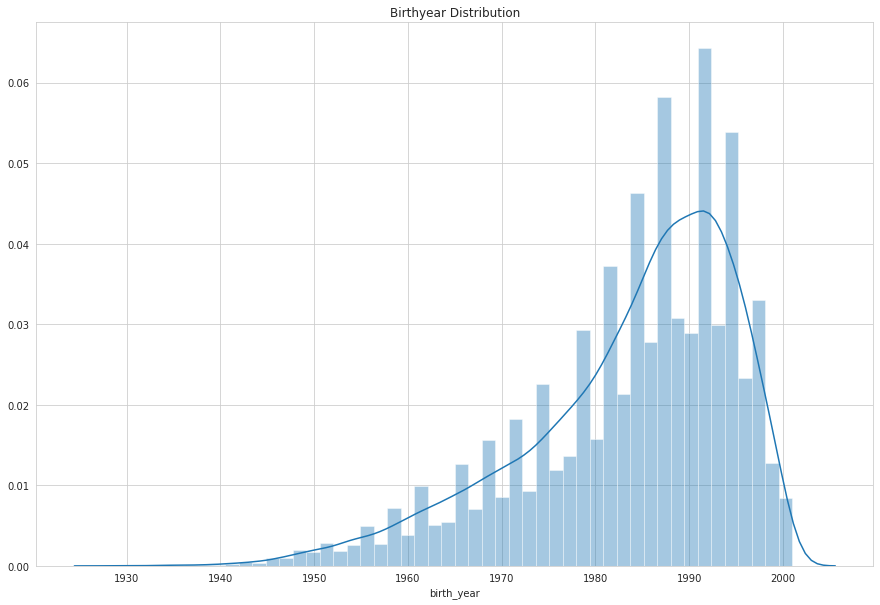

In [25]:
# plot the histogram for Birthyear
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

sns.distplot(data_user['birth_year']).set_title('Birthyear Distribution')

INFO:root:Read users into Dataframe


[Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Poland'),
 Text(0, 0, 'France'),
 Text(0, 0, 'Ireland'),
 Text(0, 0, 'Romania'),
 Text(0, 0, 'Spain'),
 Text(0, 0, 'Lithuania'),
 Text(0, 0, 'Portugal'),
 Text(0, 0, 'Malta'),
 Text(0, 0, 'Germany')]

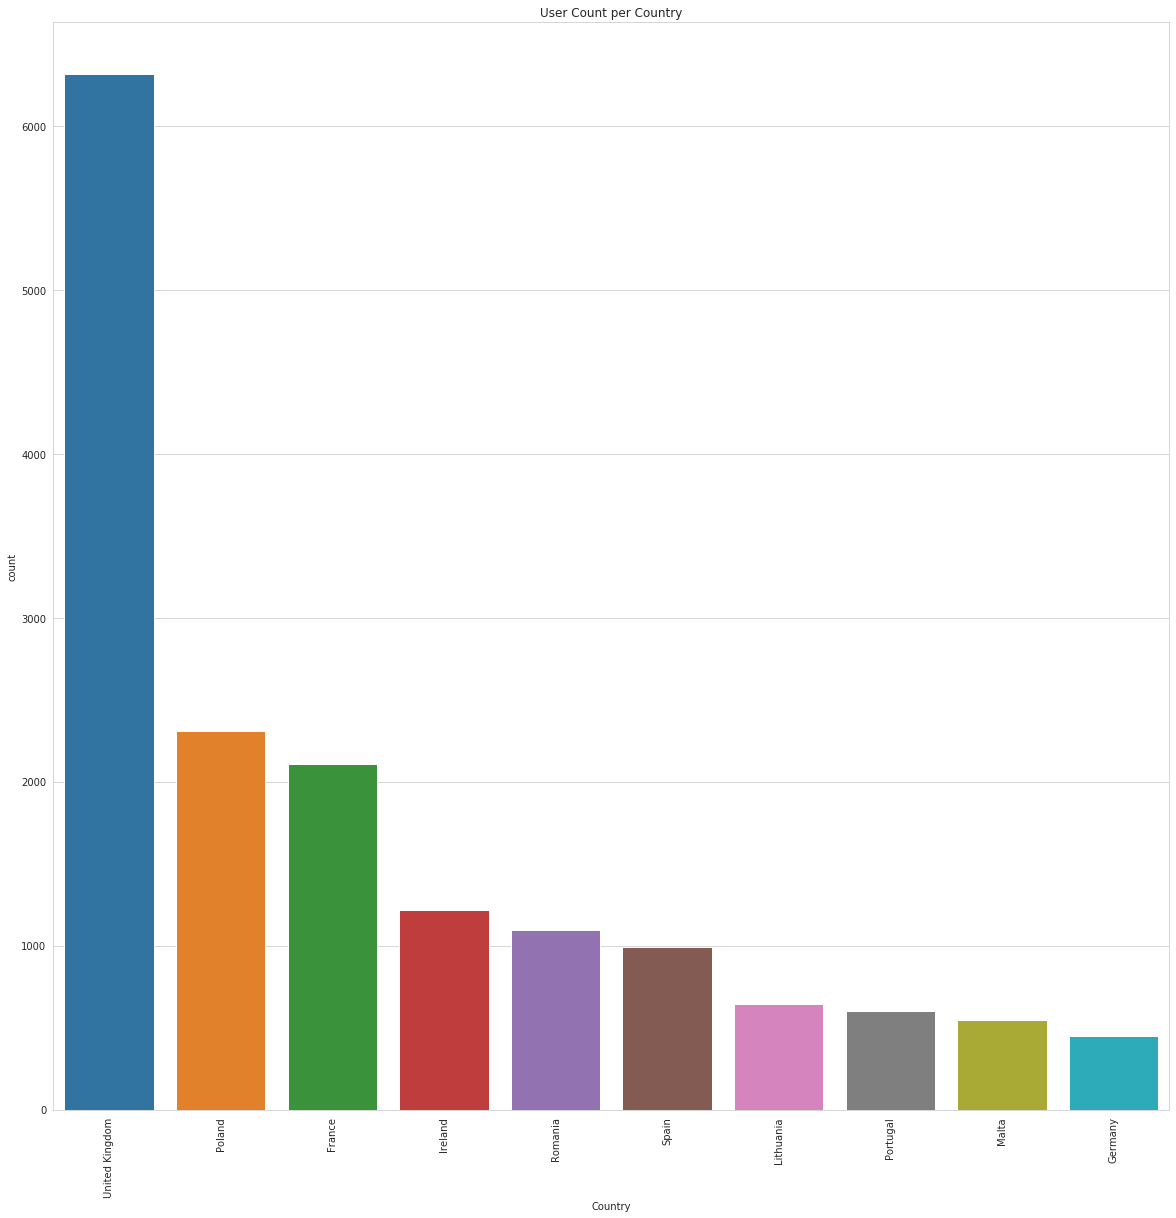

In [26]:
# gather user per country data
logging.info("Read users into Dataframe")
data_user_groupby_country = pd.read_sql('SELECT count(user_id), country FROM users group by country', conn)

# integrate iso a2 code data so that full country names will be shown as x labels
data_iso_codes = pd.read_csv('../data/data_isoa2.csv')
data_iso_codes.columns = ['Country', 'Code']

data_user_groupby_country = data_user_groupby_country.merge(data_iso_codes,left_on='country',right_on='Code')

data_user_groupby_country.sort_values(by=['count'], ascending=False, inplace=True)
# here we will only take top 10 countries for ease of visualization
data_user_groupby_country = data_user_groupby_country.head(10)

# plot the number of users for each country
fig, axis = plt.subplots(1,1,figsize=(20,20))

sns.barplot(x='Country', y='count', data=data_user_groupby_country, order=data_user_groupby_country['Country'].unique(), ax=axis)
axis.set_xticks(range(len(data_user_groupby_country['Country'].unique())))
axis.set_title('User Count per Country')
axis.set_xticklabels(data_user_groupby_country['Country'].unique(), rotation=90)

In [27]:
# gather user per plan data
logging.info("Read users into Dataframe")
data_user_groupby_plan = pd.read_sql('SELECT count(user_id), plan FROM users group by plan', conn)

INFO:root:Read users into Dataframe


In [28]:
data_user_groupby_plan

,count,plan
0,25,PREMIUM_OFFER
1,507,METAL
2,17992,STANDARD
3,37,METAL_FREE
4,4,PREMIUM_FREE
5,865,PREMIUM


Due to the nature of the distribution, we will use log scale for visualization

[Text(0, 0, 'STANDARD'),
 Text(0, 0, 'PREMIUM'),
 Text(0, 0, 'METAL'),
 Text(0, 0, 'METAL_FREE'),
 Text(0, 0, 'PREMIUM_OFFER'),
 Text(0, 0, 'PREMIUM_FREE')]

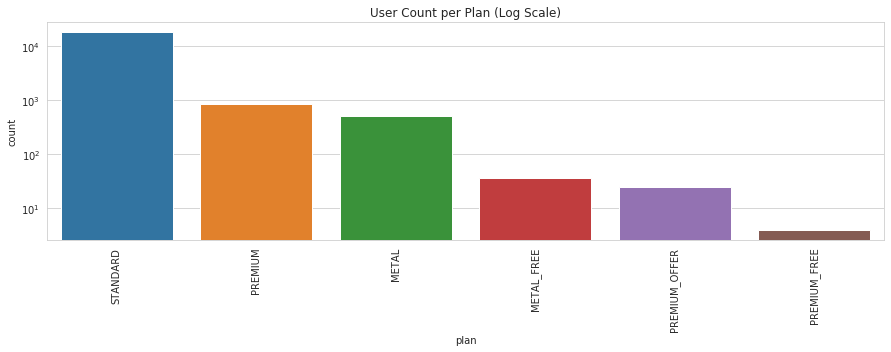

In [29]:
data_user_groupby_plan.sort_values(by=['count'], ascending=False, inplace=True)

# plot the number of users for each country
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='plan', y='count', data=data_user_groupby_plan, order=data_user_groupby_plan['plan'].unique(), ax=axis).set_yscale('log')
axis.set_xticks(range(len(data_user_groupby_plan['plan'].unique())))
axis.set_title('User Count per Plan (Log Scale)')
axis.set_xticklabels(data_user_groupby_plan['plan'].unique(), rotation=90)

Text(0.5, 1.0, 'Number of Contacts Distribution')

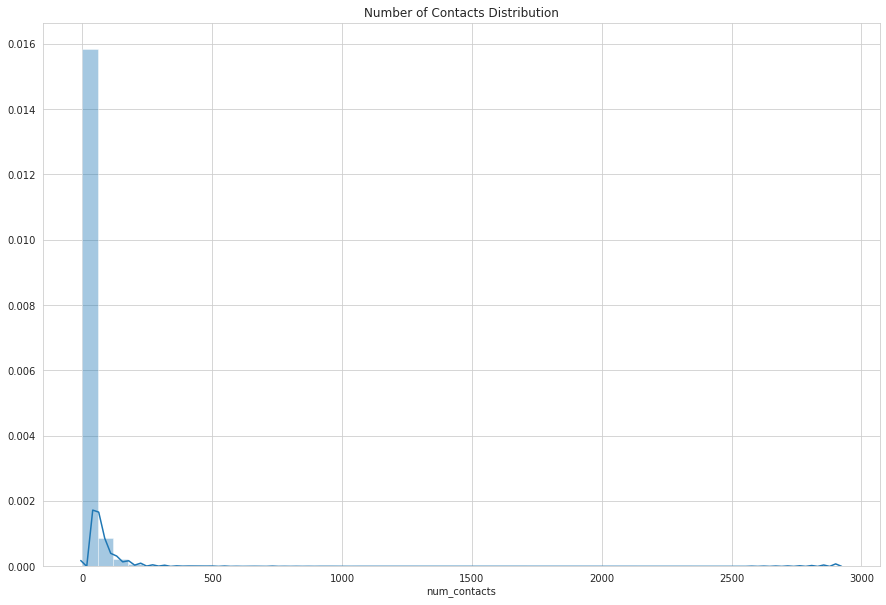

In [30]:
# plot the histogram for num_contacts
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

sns.distplot(data_user['num_contacts']).set_title('Number of Contacts Distribution')

INFO:root:Read transactions into Dataframe


[Text(0, 0, 'COMPLETED'),
 Text(0, 0, 'DECLINED'),
 Text(0, 0, 'REVERTED'),
 Text(0, 0, 'FAILED'),
 Text(0, 0, 'PENDING'),
 Text(0, 0, 'CANCELLED')]

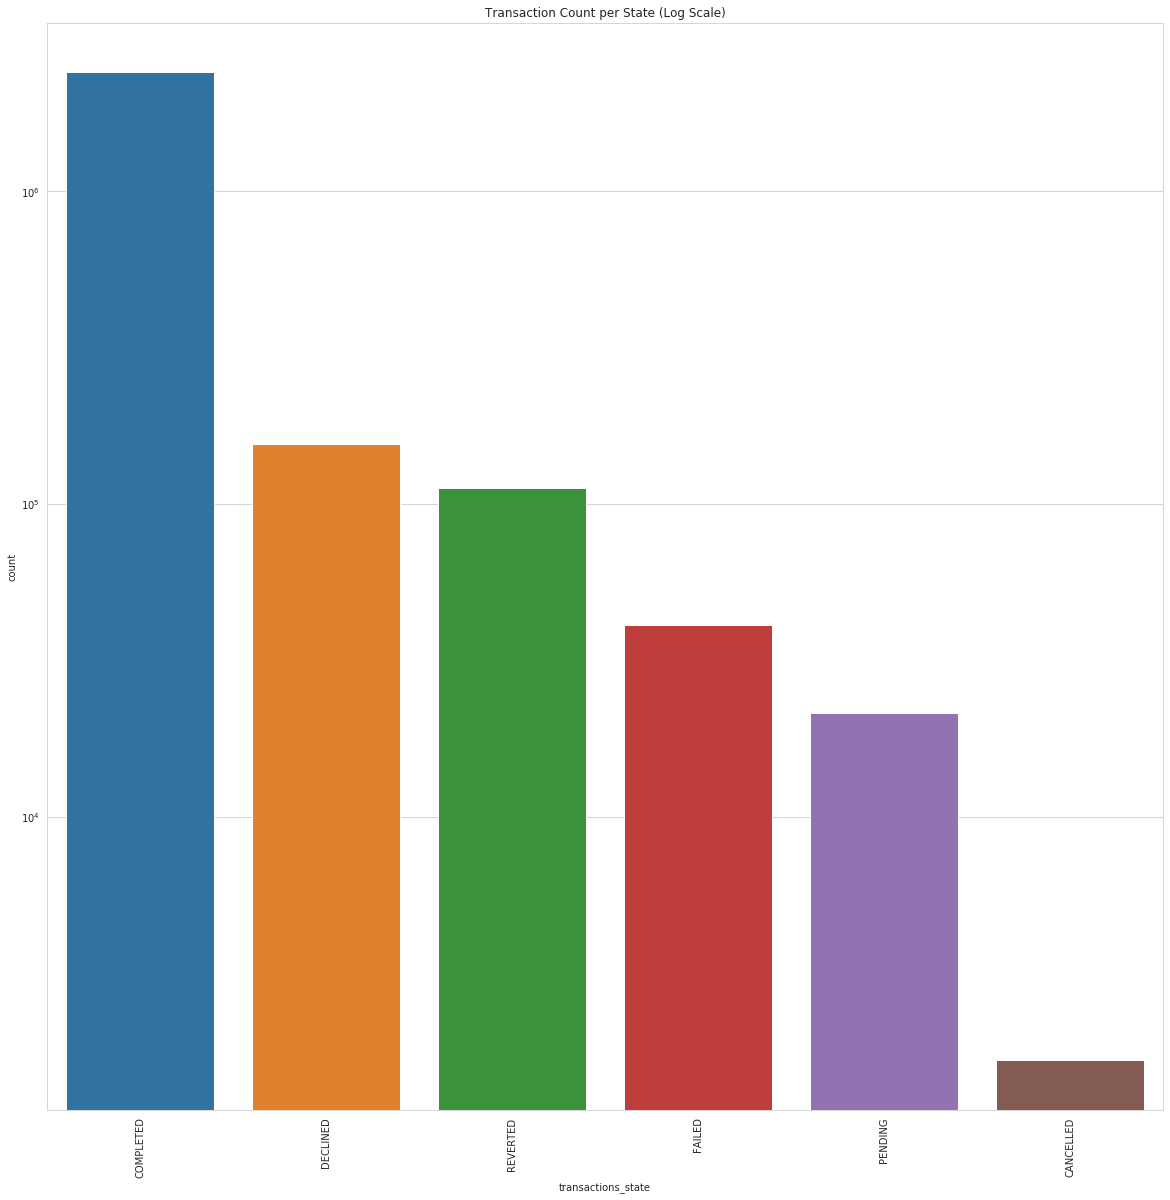

In [31]:
# gather transactions per state data
logging.info("Read transactions into Dataframe")
data_transactions_groupby_state = pd.read_sql('SELECT count(transaction_id), transactions_state FROM transactions group by transactions_state', conn)

data_transactions_groupby_state.sort_values(by=['count'], ascending=False, inplace=True)
# plot the number of transactions for each state
fig, axis = plt.subplots(1,1,figsize=(20,20))

sns.barplot(x='transactions_state', y='count', data=data_transactions_groupby_state, order=data_transactions_groupby_state['transactions_state'].unique(), ax=axis).set_yscale('log')
axis.set_xticks(range(len(data_transactions_groupby_state['transactions_state'].unique())))
axis.set_title('Transaction Count per State (Log Scale)')
axis.set_xticklabels(data_transactions_groupby_state['transactions_state'].unique(), rotation=90)

INFO:root:Read transactions into Dataframe


[Text(0, 0, 'CARD_PAYMENT'),
 Text(0, 0, 'TRANSFER'),
 Text(0, 0, 'TOPUP'),
 Text(0, 0, 'EXCHANGE'),
 Text(0, 0, 'ATM'),
 Text(0, 0, 'CASHBACK'),
 Text(0, 0, 'FEE'),
 Text(0, 0, 'CARD_REFUND'),
 Text(0, 0, 'TAX'),
 Text(0, 0, 'REFUND')]

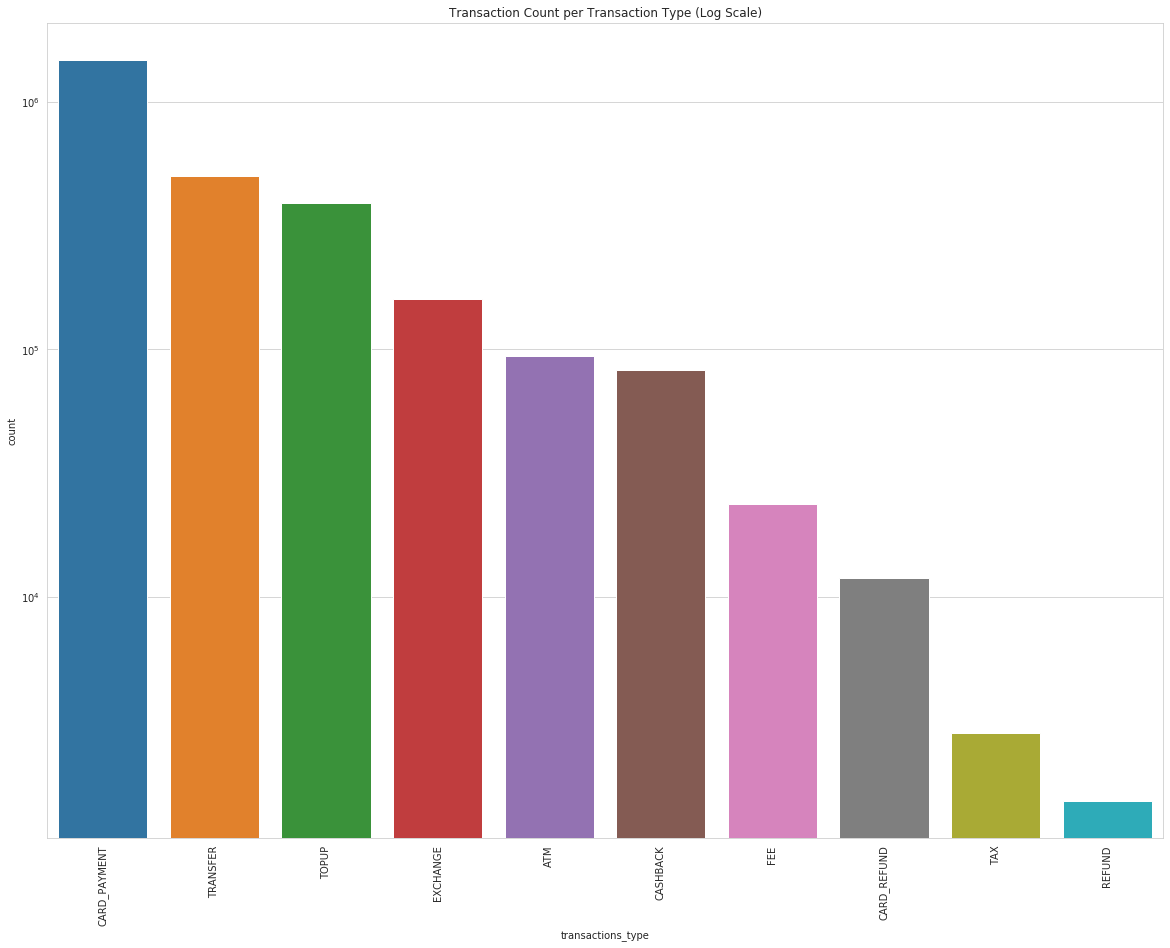

In [32]:
# gather transactions per type data
logging.info("Read transactions into Dataframe")
data_transactions_groupby_type = pd.read_sql('SELECT count(transaction_id), transactions_type FROM transactions group by transactions_type', conn)

data_transactions_groupby_type.sort_values(by=['count'], ascending=False, inplace=True)
# plot the number of transactions for each state
fig, axis = plt.subplots(1,1,figsize=(20,15))

sns.barplot(x='transactions_type', y='count', data=data_transactions_groupby_type, order=data_transactions_groupby_type['transactions_type'].unique(), ax=axis).set_yscale('log')
axis.set_xticks(range(len(data_transactions_groupby_type['transactions_type'].unique())))
axis.set_title('Transaction Count per Transaction Type (Log Scale)')
axis.set_xticklabels(data_transactions_groupby_type['transactions_type'].unique(), rotation=90)

INFO:root:Read transactions into Dataframe


[Text(0, 0, 'OUTBOUND'), Text(0, 0, 'INBOUND')]

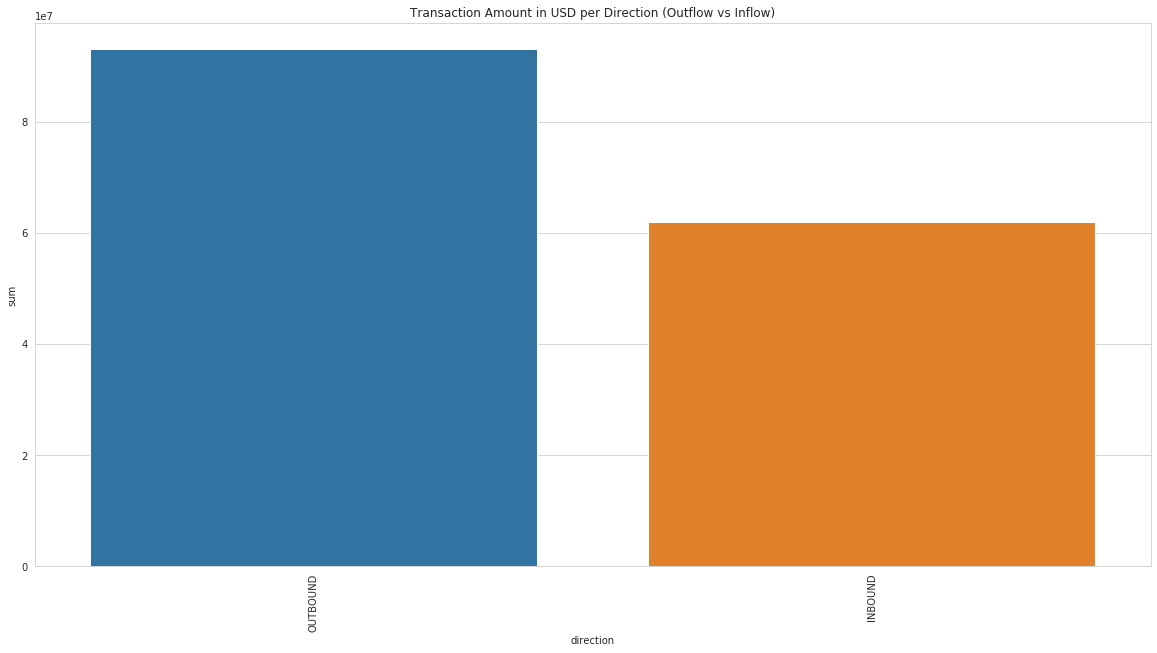

In [33]:
# gather transactions per direction data
logging.info("Read transactions into Dataframe")
data_transactions_groupby_direction = pd.read_sql('SELECT sum(amount_usd), direction FROM transactions where transactions_state = \'COMPLETED\' group by direction', conn)

data_transactions_groupby_direction.sort_values(by=['sum'], ascending=False, inplace=True)
# plot the number of transactions for each state
fig, axis = plt.subplots(1,1,figsize=(20,10))

sns.barplot(x='direction', y='sum', data=data_transactions_groupby_direction, order=data_transactions_groupby_direction['direction'].unique(), ax=axis)
axis.set_xticks(range(len(data_transactions_groupby_direction['direction'].unique())))
axis.set_title('Transaction Amount in USD per Direction (Outflow vs Inflow)')
axis.set_xticklabels(data_transactions_groupby_direction['direction'].unique(), rotation=90)

## 2. Merge Data

1) Merge Devices Data with User Data

In [34]:
data_user.shape

(19430, 10)

In [35]:
data_devices.shape

(19430, 2)

Seems like there is a one-to-one mapping relationship between user and device, this means one user has only at most one device linked to him/her.

In [36]:
# rename the column brand before merging with data_user
data_devices.rename(columns={'brand':'device_brand'}, inplace=True)
# merge user datatable with devices datatable
data_user = data_user.merge(data_devices,on='user_id')

In [37]:
# See the time span of all transactions
data_transactions_time_span = pd.read_sql('SELECT min(created_date), max(created_date) FROM transactions', conn)

We will choose 6 months as calibration period, the 3 months afterwards as holdout period, going backwards from max(created_date) from transactions, which is 2019-05-16 18:22:16.959896

In [38]:
# This means:
from datetime import datetime, timedelta

holdout_end = data_transactions_time_span['max'].loc[0]
holdout_start = holdout_end - pd.DateOffset(months=3)
calibration_end = holdout_start
calibration_start = holdout_start - pd.DateOffset(months=6)

2) Merge Notifications Data with User Data

In [39]:
data_notifications_calibration = data_notifications[(data_notifications['created_date']>calibration_start)
                                                    &(data_notifications['created_date']<calibration_end)]
data_notifications_holdout = data_notifications[(data_notifications['created_date']>holdout_start)
                                                    &(data_notifications['created_date']<holdout_end)]

In [40]:
data_notifications_calibration.shape

(80573, 5)

In [41]:
data_notifications_holdout.shape

(23493, 5)

Creating features from notifications

In [42]:
data_notifications_calibration_agg = data_notifications_calibration.groupby('user_id').agg({'created_date': 'count'}).reset_index()
data_notifications_calibration_agg.columns = ['user_id', 'notifications_total_count']

data_notifications_calibration_crosstab_reason = pd.crosstab(data_notifications_calibration['user_id'], data_notifications_calibration['reason']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_calibration_crosstab_reason.columns = ['notifications_reason_'+col if col!='user_id' else col for col in data_notifications_calibration_crosstab_reason.columns]
data_notifications_calibration_crosstab_channel = pd.crosstab(data_notifications_calibration['user_id'], data_notifications_calibration['channel']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_calibration_crosstab_channel.columns = ['notifications_channel_'+col if col!='user_id' else col for col in data_notifications_calibration_crosstab_channel.columns]
data_notifications_calibration_crosstab_status = pd.crosstab(data_notifications_calibration['user_id'], data_notifications_calibration['status']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_calibration_crosstab_status.columns = ['notifications_status_'+col if col!='user_id' else col for col in data_notifications_calibration_crosstab_status.columns]

data_notifications_holdout_agg = data_notifications_holdout.groupby('user_id').agg({'created_date': 'count'}).reset_index()
data_notifications_holdout_agg.columns = ['user_id', 'notifications_total_count']

data_notifications_holdout_crosstab_reason = pd.crosstab(data_notifications_holdout['user_id'], data_notifications_holdout['reason']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_holdout_crosstab_reason.columns = ['notifications_reason_'+col if col!='user_id' else col for col in data_notifications_holdout_crosstab_reason.columns]
data_notifications_holdout_crosstab_channel = pd.crosstab(data_notifications_holdout['user_id'], data_notifications_holdout['channel']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_holdout_crosstab_channel.columns = ['notifications_channel_'+col if col!='user_id' else col for col in data_notifications_holdout_crosstab_channel.columns]
data_notifications_holdout_crosstab_status = pd.crosstab(data_notifications_holdout['user_id'], data_notifications_holdout['status']).reset_index()
# adding specific column prefix before merging with data_user
data_notifications_holdout_crosstab_status.columns = ['notifications_status_'+col if col!='user_id' else col for col in data_notifications_holdout_crosstab_status.columns]

In [43]:
data_notifications_calibration_merged = data_notifications_calibration_crosstab_reason.merge(data_notifications_calibration_crosstab_channel,on='user_id').merge(data_notifications_calibration_crosstab_status,on='user_id').merge(data_notifications_calibration_agg,on='user_id')
data_notifications_holdout_merged = data_notifications_holdout_crosstab_reason.merge(data_notifications_holdout_crosstab_channel,on='user_id').merge(data_notifications_holdout_crosstab_status,on='user_id').merge(data_notifications_holdout_agg,on='user_id')

from functools import reduce
data_notifications_calibration_merged = reduce(lambda x,y: pd.merge(x,y, on='user_id', how='inner'), 
                                              [data_notifications_calibration_agg, 
                                               data_notifications_calibration_crosstab_reason, 
                                               data_notifications_calibration_crosstab_channel,
                                               data_notifications_calibration_crosstab_status
                                              ])

data_notifications_holdout_merged = reduce(lambda x,y: pd.merge(x,y, on='user_id', how='inner'), 
                                              [data_notifications_holdout_agg, 
                                               data_notifications_holdout_crosstab_reason, 
                                               data_notifications_holdout_crosstab_channel,
                                               data_notifications_holdout_crosstab_status
                                              ])

In [44]:
data_user_calibration = data_user.merge(data_notifications_calibration_merged, on='user_id', how='left')
data_user_holdout = data_user.merge(data_notifications_holdout_merged, on='user_id', how='left')

In [45]:
data_user_calibration.shape

(19430, 33)

In [46]:
data_user_holdout.shape

(19430, 26)

In [47]:
len(list(set(data_user_calibration['user_id'].unique()) & set(data_user_holdout['user_id'].unique())))

19430

3) Merge Transactions Data with User Data

In [48]:
data_transactions_calibration = data_transactions[(data_transactions['created_date']>calibration_start)
                                                    &(data_transactions['created_date']<calibration_end)]
data_transactions_holdout = data_transactions[(data_transactions['created_date']>holdout_start)
                                                    &(data_transactions['created_date']<holdout_end)]

In [49]:
len(list(set(data_transactions_calibration['user_id'].unique()) & set(data_transactions_holdout['user_id'].unique())))

13360

In [50]:
data_transactions_calibration.shape

(1382465, 12)

In [51]:
data_transactions_holdout.shape

(901174, 12)

In [52]:
data_transactions_calibration.head(20)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
12,transaction_12,TRANSFER,AED,61.99,COMPLETED,None,NaN,None,None,OUTBOUND,user_5496,2018-09-07 03:41:24.499256
13,transaction_13,EXCHANGE,AED,1.03,COMPLETED,None,NaN,None,None,OUTBOUND,user_5496,2018-09-07 13:24:45.807256
14,transaction_14,EXCHANGE,AED,0.21,COMPLETED,None,NaN,None,None,OUTBOUND,user_4896,2018-09-09 06:38:46.519780
15,transaction_15,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,5541.0,Abu Dhabi,ARE,OUTBOUND,user_5496,2018-09-08 10:24:50.779256
16,transaction_16,EXCHANGE,AED,1.03,COMPLETED,None,NaN,None,None,OUTBOUND,user_5496,2018-09-07 08:58:15.946256
17,transaction_17,EXCHANGE,AED,1.03,COMPLETED,None,NaN,None,None,OUTBOUND,user_5496,2018-09-07 10:05:10.848256
18,transaction_18,CARD_PAYMENT,AED,9.30,COMPLETED,FALSE,5331.0,Dubai,ARE,OUTBOUND,user_5496,2018-09-07 13:24:45.714256
19,transaction_19,EXCHANGE,AED,1.03,COMPLETED,None,NaN,None,None,OUTBOUND,user_5496,2018-09-08 10:24:50.871256
20,transaction_20,CARD_PAYMENT,AED,33.06,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_4896,2018-09-20 05:19:51.017780
21,transaction_21,CARD_PAYMENT,AED,15.19,COMPLETED,FALSE,5814.0,Auh,ARE,OUTBOUND,user_2206,2018-10-03 05:54:45.909179


Creating features from transactions

In [53]:
data_transactions_calibration_agg = data_transactions_calibration.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_calibration_agg.columns = ['user_id', 'transactions_total_count', 'transactions_total_sum']

# features from transactions_type
data_transactions_calibration_crosstab_type = pd.crosstab(data_transactions_calibration['user_id'], data_transactions_calibration['transactions_type']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_calibration_crosstab_type.columns = ['transactions_type_'+col if col!='user_id' else col for col in data_transactions_calibration_crosstab_type.columns]
# features from transactions_state
data_transactions_calibration_crosstab_state = pd.crosstab(data_transactions_calibration['user_id'], data_transactions_calibration['transactions_state']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_calibration_crosstab_state.columns = ['transactions_state_'+col if col!='user_id' else col for col in data_transactions_calibration_crosstab_state.columns]
# features from direction
data_transactions_calibration_crosstab_direction = pd.crosstab(data_transactions_calibration['user_id'], data_transactions_calibration['direction']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_calibration_crosstab_direction.columns = ['transactions_direction_'+col if col!='user_id' else col for col in data_transactions_calibration_crosstab_direction.columns]

data_transactions_holdout_agg = data_transactions_holdout.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_holdout_agg.columns = ['user_id', 'transactions_total_count', 'transactions_total_sum']

# features from transactions_type
data_transactions_holdout_crosstab_type = pd.crosstab(data_transactions_holdout['user_id'], data_transactions_holdout['transactions_type']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_holdout_crosstab_type.columns = ['transactions_type_'+col if col!='user_id' else col for col in data_transactions_holdout_crosstab_type.columns]
# features from transactions_state
data_transactions_holdout_crosstab_state = pd.crosstab(data_transactions_holdout['user_id'], data_transactions_holdout['transactions_state']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_holdout_crosstab_state.columns = ['transactions_state_'+col if col!='user_id' else col for col in data_transactions_holdout_crosstab_state.columns]
# features from direction
data_transactions_holdout_crosstab_direction = pd.crosstab(data_transactions_holdout['user_id'], data_transactions_holdout['direction']).reset_index()
# adding specific column prefix before merging with data_user
data_transactions_holdout_crosstab_direction.columns = ['transactions_direction_'+col if col!='user_id' else col for col in data_transactions_holdout_crosstab_direction.columns]


In [54]:
# features from completed transactions
data_transactions_calibration_completed = data_transactions_calibration[data_transactions_calibration['transactions_state']=='COMPLETED']
data_transactions_calibration_completed_agg = data_transactions_calibration_completed.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_calibration_completed_agg.columns = ['user_id', 'transactions_completed_total_count', 'transactions_completed_total_sum']

# features from completed inbound transactions
data_transactions_calibration_completed_inbound = data_transactions_calibration_completed[data_transactions_calibration_completed['direction']=='INBOUND']
data_transactions_calibration_completed_inbound_agg = data_transactions_calibration_completed_inbound.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_calibration_completed_inbound_agg.columns = ['user_id', 'transactions_completed_inbound_total_count', 'transactions_completed_inbound_total_sum']

# features from completed outbound transactions
data_transactions_calibration_completed_outbound = data_transactions_calibration_completed[data_transactions_calibration_completed['direction']=='OUTBOUND']
data_transactions_calibration_completed_outbound_agg = data_transactions_calibration_completed_outbound.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_calibration_completed_outbound_agg.columns = ['user_id', 'transactions_completed_outbound_total_count', 'transactions_completed_outbound_total_sum']

# features from completed transactions
data_transactions_holdout_completed = data_transactions_holdout[data_transactions_holdout['transactions_state']=='COMPLETED']
data_transactions_holdout_completed_agg = data_transactions_holdout_completed.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_holdout_completed_agg.columns = ['user_id', 'transactions_completed_total_count', 'transactions_completed_total_sum']

# features from completed inbound transactions
data_transactions_holdout_completed_inbound = data_transactions_holdout_completed[data_transactions_holdout_completed['direction']=='INBOUND']
data_transactions_holdout_completed_inbound_agg = data_transactions_holdout_completed_inbound.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_holdout_completed_inbound_agg.columns = ['user_id', 'transactions_completed_inbound_total_count', 'transactions_completed_inbound_total_sum']

# features from completed outbound transactions
data_transactions_holdout_completed_outbound = data_transactions_holdout_completed[data_transactions_holdout_completed['direction']=='OUTBOUND']
data_transactions_holdout_completed_outbound_agg = data_transactions_holdout_completed_outbound.groupby('user_id').agg({'created_date': 'count', 'amount_usd':'sum'}).reset_index()
data_transactions_holdout_completed_outbound_agg.columns = ['user_id', 'transactions_completed_outbound_total_count', 'transactions_completed_outbound_total_sum']


In [55]:
from functools import reduce
data_transactions_calibration_merged = reduce(lambda x,y: pd.merge(x,y, on='user_id', how='outer'), 
                                              [data_transactions_calibration_agg, 
                                               data_transactions_calibration_crosstab_type, 
                                               data_transactions_calibration_crosstab_state,
                                               data_transactions_calibration_crosstab_direction,
                                               data_transactions_calibration_completed_agg,
                                               data_transactions_calibration_completed_inbound_agg,
                                               data_transactions_calibration_completed_outbound_agg
                                              ])

data_transactions_holdout_merged = reduce(lambda x,y: pd.merge(x,y, on='user_id', how='outer'), 
                                              [data_transactions_holdout_agg, 
                                               data_transactions_holdout_crosstab_type, 
                                               data_transactions_holdout_crosstab_state,
                                               data_transactions_holdout_crosstab_direction,
                                               data_transactions_holdout_completed_agg,
                                               data_transactions_holdout_completed_inbound_agg,
                                               data_transactions_holdout_completed_outbound_agg
                                              ])

4) Create the final summary data and convert categorical data with one-hot-encoding

In [56]:
data_user_calibration_summary = data_user_calibration.merge(data_transactions_calibration_merged, on='user_id', how='right')
data_user_holdout_summary = data_user_holdout.merge(data_transactions_holdout_merged, on='user_id', how='right')

In [57]:
# write the summary data for calibration and holdout into .csv file
data_user_calibration_summary.to_csv('../data/calibration_summary.csv',index=False, encoding='utf-8', sep=';')
data_user_holdout_summary.to_csv('../data/holdout_summary.csv',index=False, encoding='utf-8', sep=';')

In [58]:
from sklearn.model_selection import train_test_split

def split_data(calibration_summary, holdout_summary):
    calibration_summary.reset_index(inplace=True)
    calibration_summary.set_index('user_id', inplace=True)
    holdout_summary.set_index('user_id', inplace=True)

    real_users_not_alive_index = list(
        set(calibration_summary['transactions_total_count'].index) - set(holdout_summary['transactions_total_count'].index))

    is_alive = pd.DataFrame(index=calibration_summary['transactions_total_count'].index)
    is_alive['real'] = 1

    is_alive.loc[real_users_not_alive_index, 'real'] = 0

    X_train, X_test, y_train, y_test =\
        train_test_split(calibration_summary, is_alive['real'], test_size=0.1, random_state=42)

    return X_train, X_test, y_train, y_test

In [59]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

# here city and created_date will be excluded
# city is excluded as this will cause thousands of new columns to be created after one_hot_encoding
data_user_calibration_summary_one_hot = one_hot(data_user_calibration_summary, ['country', 'plan', 'device_brand'])
data_user_holdout_summary = one_hot(data_user_holdout_summary, ['country', 'plan', 'device_brand'])

features_to_drop = ['Index', 'index', 'created_date', 'city', 'country', 'plan', 'device_brand']
features_x = []
for col in data_user_calibration_summary.columns:
    if col in features_to_drop:
        pass
    else:
        features_x.append(col)


X_train, X_test, y_train, y_test =\
    split_data(data_user_calibration_summary_one_hot[features_x], data_user_holdout_summary)

## 3. Train the model - xgboost, while optimizing hyperparameters with Bayesian Optimization

In [60]:
# convert the training data into DMatrix for xgboost
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)


/home/jiacheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [61]:
from sklearn.model_selection import cross_val_score
import warnings

def xgboostcv(max_depth,
              learning_rate,
              n_estimators,
              gamma,
              min_child_weight,
              max_delta_step,
              subsample,
              colsample_bytree,
              reg_alpha,
              reg_lambda,
              silent=True,
              nthread=-1,
              random_state=1):
    return cross_val_score(xgb.XGBClassifier(max_depth=int(max_depth),
                                             learning_rate=learning_rate,
                                             n_estimators=int(n_estimators),
                                             silent=silent,
                                             nthread=nthread,
                                             gamma=gamma,
                                             min_child_weight=min_child_weight,
                                             max_delta_step=max_delta_step,
                                             subsample=subsample,
                                             colsample_bytree=colsample_bytree,
                                             reg_alpha=reg_alpha,
                                             reg_lambda = reg_lambda),
                           X_train,
                           y_train,
                           cv=5,
                           scoring="roc_auc",
                           n_jobs=-1).mean()

xgboostBO = BayesianOptimization(xgboostcv,
                                 {'max_depth': (2, 5),
                                  'learning_rate': (0.01, 0.3),
                                  'n_estimators': (1000, 2500),
                                  'gamma': (1., 0.01),
                                  'min_child_weight': (1, 10),
                                  'max_delta_step': (0, 0.1),
                                  'subsample': (0.5, 0.8),
                                  'colsample_bytree' :(0.1, 0.99),
                                  'reg_alpha':(0.1, 0.5),
                                  'reg_lambda':(0.1, 0.9)
                                  })

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgboostBO.maximize(init_points=2, n_iter=5, acq='ei', xi=0.0)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8531   |  0.5922   |  0.853    |  0.08366  |  0.04624  |  3.114    |  8.852    |  1.07e+03 |  0.2378   |  0.1691   |  0.6087   |
|  2        |  0.8565   |  0.3065   |  0.365    |  0.1455   |  0.05484  |  3.371    |  7.957    |  1.375e+0 |  0.193    |  0.8823   |  0.5261   |
|  3        |  0.8421   |  0.3776   |  1.0      |  0.08684  |  0.01258  |  2.676    |  3.061    |  2.5e+03  |  0.1243   |  0.5009   |  0.7045   |
|  4        |  0.8556   |  0.7377   |  1.0      |  0.2596   |  0.03047  |  2.005    |  1.024    |  1.574e+0 |  0.3577   |  0.1548   |  0.5312   |
|  5        |  0.8463   |  0.7705   |  1.0      |  0.1919   |  0.07277  |  4.815    |  9.972    |  1.546e+0 |  0.2261   |  0

In [62]:
logging.info('-'*100)
logging.info('Final Results')
logging.info('Maximum XGBOOST value: %f' % xgboostBO.max['target'])
logger.info("Loging dict ---> {0}".format(xgboostBO.max['params']))

INFO:root:----------------------------------------------------------------------------------------------------
INFO:root:Final Results
INFO:root:Maximum XGBOOST value: 0.856539
INFO:root:Loging dict ---> {'colsample_bytree': 0.3065118616189617, 'gamma': 0.36504507635039596, 'learning_rate': 0.14551547130071443, 'max_delta_step': 0.05484336163288087, 'max_depth': 3.3713667177782196, 'min_child_weight': 7.957293193001172, 'n_estimators': 1375.0585535130976, 'reg_alpha': 0.1929739111617242, 'reg_lambda': 0.8822875534872391, 'subsample': 0.5260662829748117}


In [63]:
max_params = xgboostBO.max['params']
max_params['max_depth'] = int(max_params['max_depth'])

In [64]:
xgb_final_model = xgb.XGBClassifier(max_depth=max_params['max_depth'],
                                             learning_rate=max_params['learning_rate'],
                                             n_estimators=int(max_params['n_estimators']),
                                             silent=True,
                                             nthread=-1,
                                             gamma=max_params['gamma'],
                                             min_child_weight=max_params['min_child_weight'],
                                             max_delta_step=max_params['max_delta_step'],
                                             subsample=max_params['subsample'],
                                             colsample_bytree=max_params['colsample_bytree'],
                                             reg_alpha=max_params['reg_alpha'],
                                             reg_lambda = max_params['reg_lambda'])

In [65]:
xgb_final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3065118616189617,
              gamma=0.36504507635039596, learning_rate=0.14551547130071443,
              max_delta_step=0.05484336163288087, max_depth=3,
              min_child_weight=7.957293193001172, missing=None,
              n_estimators=1375, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.1929739111617242, reg_lambda=0.8822875534872391,
              scale_pos_weight=1, seed=None, silent=True,
              subsample=0.5260662829748117, verbosity=1)

In [66]:
from sklearn.metrics import f1_score
# Predict on testing and training set
y_pred = xgb_final_model.predict(X_test)
y_train_pred = xgb_final_model.predict(X_train)

# Report testing and training F1 Score
logging.info('F1 Score for Test Dataset: '+str(f1_score(y_test, y_pred)))
logging.info('F1 Score for Training Dataset: '+str(f1_score(y_train, y_train_pred)))


INFO:root:F1 Score for Test Dataset: 0.9030172413793104
INFO:root:F1 Score for Training Dataset: 0.9132507913611412


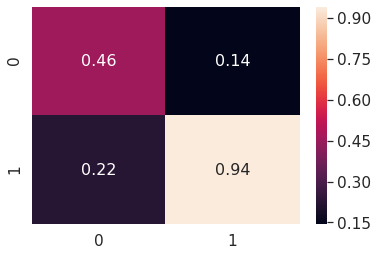

In [67]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)  
conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

Text(0.5, 1.0, 'Feature Importance')

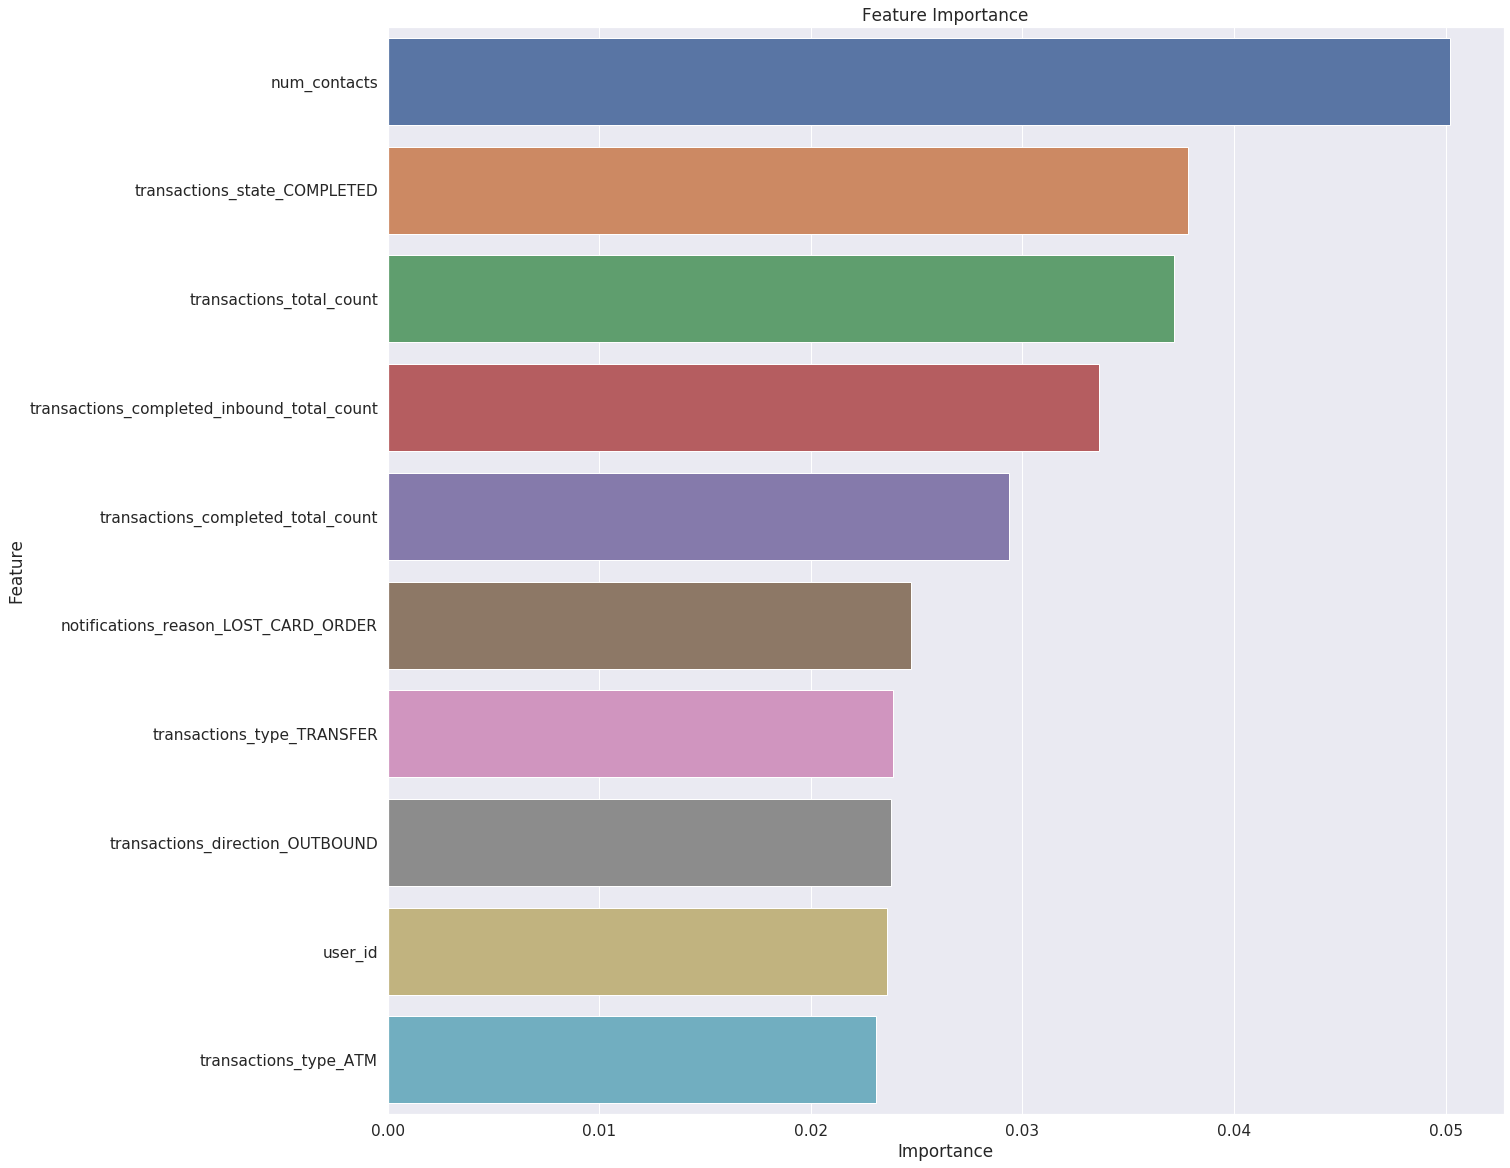

In [85]:
# plot the feature importance
feat_imp = pd.DataFrame({'Importance':xgb_final_model.feature_importances_,
                         'Feature': features_x} ).sort_values(ascending=False, by='Importance')

fig, axis = plt.subplots(1,1,figsize=(20,20))

feat_imp_top_10 = feat_imp.iloc[:10]
sns.barplot(y='Feature', x='Importance', data=feat_imp_top_10, order=feat_imp_top_10['Feature'].unique(), ax=axis)
axis.set_title('Feature Importance')

#### Note that we have user_id mistakenly also as a feature, which definitely shouldn't have happened!

We can also define other optimization metrics, such as with cost matrix if further information on costs of false positive, false negative, true positive, true negative is available.

c) Let’s assume an unengaged user is a churned user. Now suppose we use your model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn). How would you set up a test/experiment to check whether we are actually reducing churn?
        
A/B test: randomly select 2000 customers that are about to churn (as predicted by our model in b).) and divide them also randomly into 2 groups, Version A (control group) and Version B (test group): the business actions in an attempt to convert them back to engaged users will be conducted on the 1000 customers in Version B, while Version A customers receive no treatment at all. The KPI tracked here will be churn ratio and see if there is significant decrease in Version A in comparison to Version B. Of course, other KPIs could also be adopted, such as transaction volume etc. Here whether the decrease in KPI is significant could be determined with a two-sample hypothesis test, here namely **Welch's t-Test**.

Note that here the sample size 1000 is only a ballpark estimate figure. To obtain the exact sample size needed for the A/B test, we need the 

   1. **baseline conversion rate**,
   2. **the minimum detectable effect**, 
   3. **statistical power**, 
   4. **statistical significance**.

d) In the past, one business action we took to reduce churn was to re-engage inactive users. Our engagement team designed a marketing campaign, REENGAGEMENT_ACTIVE_FUNDS to remind inactive users about funds on their Revolut account. Define a metric to measure the effectiveness of the campaign. Under this metric, was the campaign effective?

Metric definition: **$\Delta Monthly Transaction Volume =$** $Monthly Transaction Volume$ after REENGAGEMENT_ACTIVE_FUNDS notification has been sent (status=SENT) - $Monthly Transaction Volume$ before REENGAGEMENT_ACTIVE_FUNDS notification has been sent (status=SENT).

The effectiveness of the campaign can be determined with a One Sample t-Test:

Hypotheses

Hₒ: $\mu \Delta Monthly Transaction Volume =0$.

Hₐ: $\mu \Delta Monthly Transaction Volume \neq0$.

$\alpha = 0.05$

In [86]:
# gather the notifications data stemming from the marketing campaign
data_campaign = data_notifications[(data_notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS') & (data_notifications['status']=='SENT')]

In [87]:
data_user.shape

(19430, 11)

In [88]:
# the number of notifications from the marketing campaign
data_campaign.shape

(28139, 5)

In [89]:
len(data_campaign['user_id'].unique())

11117

as there are only 11117 unique users treated with the marketing campaign, while the number of notifications from the marketing campaign is 28139 > 11117, this means there are users that have received more than one notifications REENGAGEMENT_ACTIVE_FUNDS 

In [90]:
data_campaign.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [91]:
# if we take one example and see:
tmp_user = 'user_7086'

data_user_tmp = pd.read_sql('SELECT * FROM users WHERE user_id = \'{}\''.format(tmp_user), conn)
data_transactions_tmp = pd.read_sql('SELECT * FROM transactions WHERE user_id = \'{}\''.format(tmp_user), conn)
data_notifications_tmp = pd.read_sql('SELECT * FROM notifications WHERE user_id = \'{}\' and reason = \'REENGAGEMENT_ACTIVE_FUNDS\''.format(tmp_user), conn)
data_devices_tmp = pd.read_sql('SELECT * FROM devices WHERE user_id = \'{}\''.format(tmp_user), conn)

In [92]:
data_transactions_tmp

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_243493,CARD_PAYMENT,PLN,1.19,COMPLETED,FALSE,5812.0,Gliwice,POL,OUTBOUND,user_7086,2018-07-06 03:28:57.017645
1,transaction_242837,TOPUP,PLN,0.20,REVERTED,None,NaN,None,None,INBOUND,user_7086,2018-06-18 17:01:36.755645
2,transaction_243494,CARD_PAYMENT,PLN,1.19,COMPLETED,FALSE,5812.0,Gliwice,POL,OUTBOUND,user_7086,2018-07-06 02:57:55.184645
3,transaction_308619,FEE,PLN,1.65,COMPLETED,None,NaN,None,None,OUTBOUND,user_7086,2018-12-09 05:55:09.789645
4,transaction_294844,CARD_PAYMENT,PLN,2.93,COMPLETED,TRUE,4215.0,Alacant,ESP,OUTBOUND,user_7086,2018-07-25 17:05:29.992645
5,transaction_298143,TOPUP,PLN,5.96,FAILED,None,NaN,None,None,INBOUND,user_7086,2018-09-19 17:18:07.415645
6,transaction_307955,TOPUP,PLN,9.94,COMPLETED,None,NaN,None,None,INBOUND,user_7086,2018-12-05 02:08:01.494645
7,transaction_300105,CARD_PAYMENT,PLN,8.04,COMPLETED,TRUE,5964.0,London,GBR,OUTBOUND,user_7086,2018-09-20 00:39:40.795645
8,transaction_300143,TOPUP,PLN,5.96,COMPLETED,None,NaN,None,None,INBOUND,user_7086,2018-09-19 17:33:09.522645
9,transaction_303738,FEE,PLN,1.65,COMPLETED,None,NaN,None,None,OUTBOUND,user_7086,2018-11-11 04:10:06.369645


In [93]:
data_notifications_tmp

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-11-17 18:12:38.112645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-21 18:03:53.943645
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-27 17:59:46.786645
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2019-01-11 17:59:44.400645
5,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2019-01-23 18:06:10.731645


In [94]:
data_campaign_agg = data_campaign.groupby(['user_id']).agg({'reason': ['count']}).reset_index()

In [95]:
data_campaign_agg.columns = ['user_id', 'reason_count']

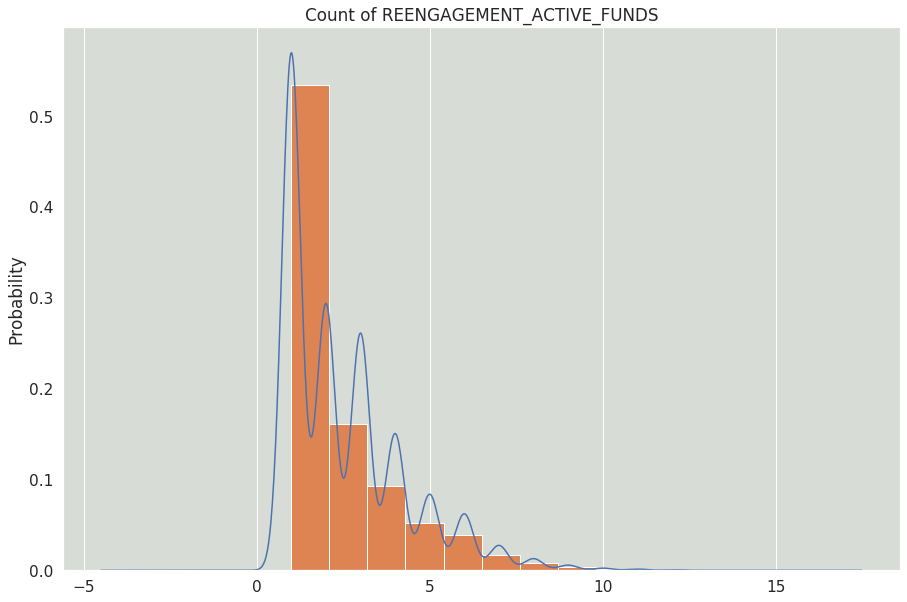

In [96]:
# Plotting the distribution of notifications per user for the marketing campaign
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(15,10))
data_campaign_agg['reason_count'].plot.kde(ax=ax, legend=False, title='Count of REENGAGEMENT_ACTIVE_FUNDS')
data_campaign_agg['reason_count'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [97]:
data_campaign_agg_contacted_once = data_campaign_agg[data_campaign_agg['reason_count']<2]

In [98]:
data_campaign_agg_contacted_once.head()

,user_id,reason_count
8,user_10007,1
9,user_10009,1
13,user_10013,1
17,user_10018,1
19,user_1002,1


Firstly, to make things simple, we only sample from the users that have only been contacted for this marketing campaign once and see if we can observe a significant change in terms of transaction volume before and after the REENGAGEMENT_ACTIVE_FUNDS notification.

In [99]:
# The result from the normality test (shown later) shows that the samples do not follow normal distribution. 
# This means we need to have sufficient sample size (therefore sample size = 100) to maintain t-Test's validity.

user_sample_list = list(data_campaign_agg_contacted_once['user_id'].sample(n=100, random_state=1))

In [100]:
from datetime import datetime
from datetime import timedelta

delta_monthly_volume_list = []
for tmp_user in user_sample_list:
    data_user_tmp =data_user[data_user['user_id']==tmp_user]

    # reverted transactions will not be counted for obvious reasons
    data_transactions_tmp = pd.read_sql('SELECT * FROM transactions WHERE user_id = \'{}\' and transactions_state <> \'REVERTED\''.format(tmp_user), conn)
    data_notifications_tmp = data_notifications[(data_notifications['user_id']==tmp_user) & (data_notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS')]

    data_transactions_tmp.rename(columns={'created_date':'transaction_date'}, inplace=True)
    data_notifications_tmp.rename(columns={'created_date':'notification_date'}, inplace=True)

    notification_time = list(data_notifications_tmp['notification_date'])[0]
    notification_time_plus = notification_time + timedelta(days=30)
    notification_time_minus = notification_time - timedelta(days=30)

    transactions_before = data_transactions_tmp[(data_transactions_tmp['transaction_date'] > notification_time_minus) 
                          & (data_transactions_tmp['transaction_date'] < notification_time)]

    transactions_after = data_transactions_tmp[(data_transactions_tmp['transaction_date'] > notification_time) 
                          & (data_transactions_tmp['transaction_date'] < notification_time_plus)]
    delta_monthly_volume = transactions_after.shape[0] - transactions_before.shape[0]
    delta_monthly_volume_list.append(delta_monthly_volume)

/home/jiacheng/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [101]:
import scipy.stats as stat# perform normality test
stat.normaltest(delta_monthly_volume_list)

NormaltestResult(statistic=63.861280964366244, pvalue=1.357372464668283e-14)

The result from the normality test shows that the samples do not follow normal distribution. This means we need to have sufficient sample size (therefore sample size = 100) to maintain t-Test's validity.

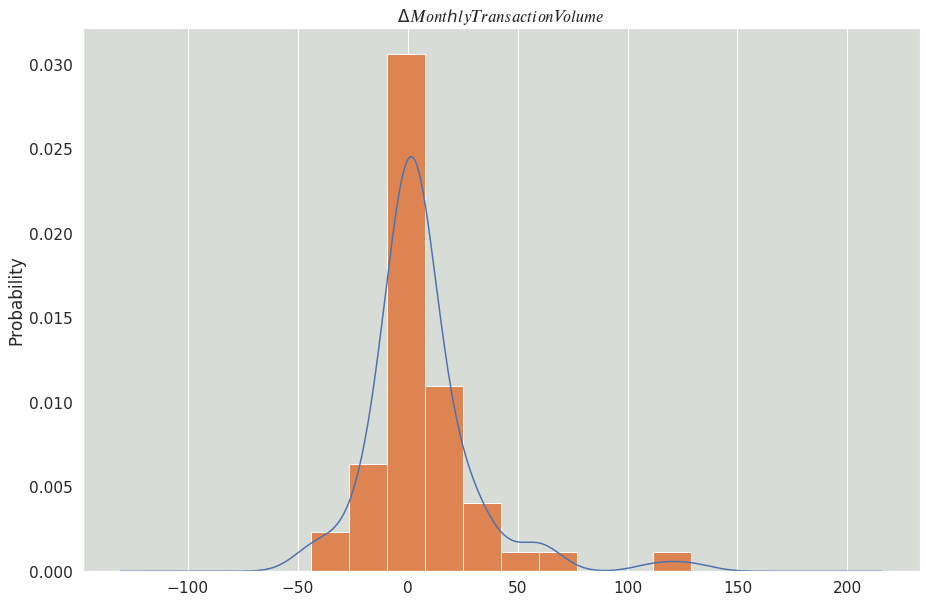

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

df_delta_monthly_volume_list = pd.Series(delta_monthly_volume_list)

fig, ax = plt.subplots(1,1,figsize=(15,10))
df_delta_monthly_volume_list.plot.kde(ax=ax, legend=False, title='$\Delta 𝑀𝑜𝑛𝑡ℎ𝑙𝑦𝑇𝑟𝑎𝑛𝑠𝑎𝑐𝑡𝑖𝑜𝑛𝑉𝑜𝑙𝑢𝑚𝑒$')
df_delta_monthly_volume_list.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [103]:
# 1 Sample t-Test Result:
stat.ttest_1samp(delta_monthly_volume_list, 0)

Ttest_1sampResult(statistic=2.554741097702788, pvalue=0.012149631713616604)

$p<\alpha$, which means Hₒ: $\mu \Delta Monthly Transaction Volume =0$ is rejected. 

**Therefore the marketing campaign is effective**!